# Sklearn Pipelining

## Chaining a PCA and a Logistic Regression

▶ **Pipeline: PCA -> Logistic Regression**

The PCA does an unsupervised dimensionality reduction, while the logistic regression does the prediction.

We use a GridSearchCV to set the dimensionality of the PCA.

Dataset: Digits Dataset, each datapoint is a 8x8 image of a digit.

Modified from [Pipelining: chaining a PCA and a logistic regression](https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html#sphx-glr-auto-examples-compose-plot-digits-pipe-py)

In [22]:
# load necessary packages
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [23]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.

# Define the elements of pipeline: PCA, StandardScaler, Logistic Regression
pca = PCA()
scaler = StandardScaler()
logistic = LogisticRegression(max_iter=10000, tol=0.05) # tol: Tolerance for stopping criteria

# Create a pipeline
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])


In [24]:
# load the dataset
X_digits, y_digits = datasets.load_digits(return_X_y=True)
X_digits.shape, y_digits.shape

((1797, 64), (1797,))

In [25]:
# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60],
    "logistic__C": np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=2) # n_jobs: Number of jobs to run in parallel
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.923):
{'logistic__C': 0.046415888336127774, 'pca__n_components': 60}


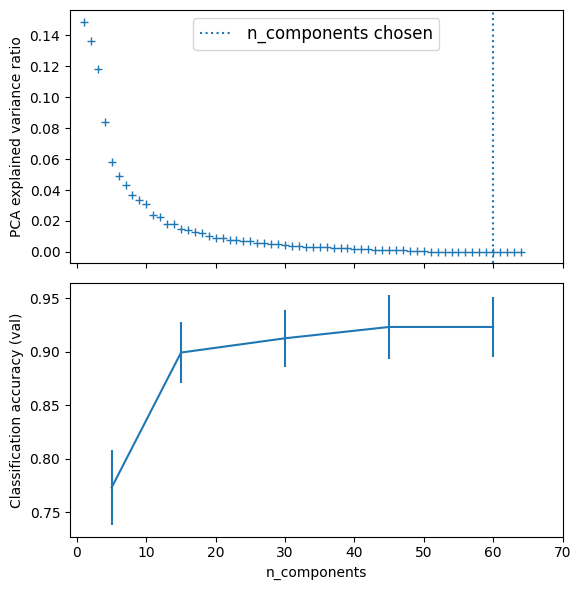

In [26]:
# Plot the PCA spectrum
pca.fit(X_digits)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    search.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
components_col = "param_pca__n_components"
is_max_test_score = pl.col("mean_test_score") == pl.col("mean_test_score").max()
best_clfs = (
    pl.LazyFrame(search.cv_results_)
    .filter(is_max_test_score.over(components_col))
    .unique(components_col)
    .sort("mean_test_score", descending=True)
    .collect()
)
ax1.errorbar(
    best_clfs[components_col],
    best_clfs["mean_test_score"],
    yerr=best_clfs["std_test_score"],
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()

## Selecting dimensionality reduction with Pipeline and GridSearchCV

▶ **Pipeline: Scaling -> Dimension Reduction -> Linear SVC(SVM)**

This example constructs a pipeline that does dimensionality reduction followed by prediction with a support vector classifier.

It demonstrates the use of ``GridSearchCV`` and ``Pipeline`` to optimize over different classes of estimators in a single CV run -- unsupervised ``PCA`` and ``NMF`` dimensionality reductions are compared to univariate feature selection during
the grid search.

Additionally, ``Pipeline`` can be instantiated with the ``memory`` argument to memoize the transformers within the pipeline, avoiding to fit again the same transformers over and over.

Note that the use of ``memory`` to enable caching becomes interesting when the fitting of a transformer is costly.


Modified from [Selecting dimensionality reduction with Pipeline and GridSearchCV](https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#sphx-glr-auto-examples-compose-plot-compare-reduction-py)

In [17]:
# load necessary packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_digits
from sklearn.decomposition import NMF, PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC

In [18]:
# load data
X, y = load_digits(return_X_y=True)

In [19]:
# create a pipeline
pipe = Pipeline(
    [
        ("scaling", MinMaxScaler()),
        # the reduce_dim stage is populated by the param_grid
        ("reduce_dim", "passthrough"),
        ("classify", LinearSVC(dual=False, max_iter=10000)),
    ]
)


In [20]:
N_FEATURES_OPTIONS = [2, 4, 8]
C_OPTIONS = [1, 10, 100, 1000]
param_grid = [
    {                                       # Non-Negative Matrix Factorization (NMF)
        "reduce_dim": [PCA(iterated_power=7), NMF(max_iter=1_000)],
        "reduce_dim__n_components": N_FEATURES_OPTIONS,
        "classify__C": C_OPTIONS,
    },
    {
        "reduce_dim": [SelectKBest(mutual_info_classif)],
        "reduce_dim__k": N_FEATURES_OPTIONS,
        "classify__C": C_OPTIONS,
    },
]

search = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid)
search.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('scaling', MinMaxScaler()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classify',
                                        LinearSVC(dual=False,
                                                  max_iter=10000))]),
             n_jobs=1,
             param_grid=[{'classify__C': [1, 10, 100, 1000],
                          'reduce_dim': [PCA(iterated_power=7),
                                         NMF(max_iter=1000)],
                          'reduce_dim__n_components': [2, 4, 8]},
                         {'classify__C': [1, 10, 100, 1000],
                          'reduce_dim': [SelectKBest(score_func=<function mutual_info_classif at 0x7d1bcba1ef80>)],
                          'reduce_dim__k': [2, 4, 8]}])

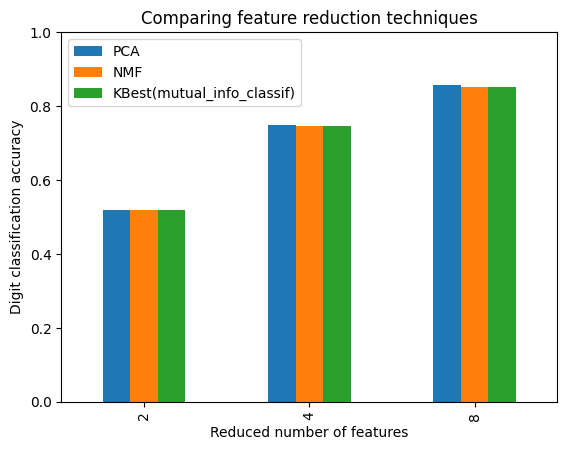

In [21]:
mean_scores = np.array(search.cv_results_["mean_test_score"])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
# create a dataframe to ease plotting
reducer_labels = ["PCA", "NMF", "KBest(mutual_info_classif)"]
mean_scores = pd.DataFrame(
    mean_scores.T, index=N_FEATURES_OPTIONS, columns=reducer_labels
)

ax = mean_scores.plot.bar()
ax.set_title("Comparing feature reduction techniques")
ax.set_xlabel("Reduced number of features")
ax.set_ylabel("Digit classification accuracy")
ax.set_ylim((0, 1))
ax.legend(loc="upper left")

plt.show()

## Toxic Comment Classification Pipeline

▶ **Pipeline: Lemmatizer -> TFIDFs -> NBFeaturer -> Logistic Regression**

Modified from [Kaggle: Sklearn pipelines tutorial](https://www.kaggle.com/code/sermakarevich/sklearn-pipelines-tutorial/notebook)

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
from scipy import sparse

from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

In [7]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
df = pd.read_csv('/content/drive/MyDrive/ML/input/toxic_comment/train.csv')
x = df['comment_text'].values[:12000]
y = df['toxic'].values[:12000]

In [5]:
class Lemmatizer(BaseEstimator):
    def __init__(self):
        self.l = WordNetLemmatizer()

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        x = map(lambda r:  ' '.join([self.l.lemmatize(i.lower()) for i in r.split()]), x)
        x = np.array(list(x))
        return x

class NBFeaturer(BaseEstimator):
    def __init__(self, alpha):
        self.alpha = alpha

    def preprocess_x(self, x, r):
        return x.multiply(r)

    def pr(self, x, y_i, y):
        p = x[y==y_i].sum(0)
        return (p+self.alpha) / ((y==y_i).sum()+self.alpha)

    def fit(self, x, y=None):
        self._r = sparse.csr_matrix(np.log(self.pr(x,1,y) / self.pr(x,0,y)))
        return self

    def transform(self, x):
        x_nb = self.preprocess_x(x, self._r)
        return x_nb

In [10]:
pipeline = Pipeline([
    ('Lemmatizer', Lemmatizer()),
    ('wc_tfidfs',
         FeatureUnion([
            ('tfidf_w', TfidfVectorizer(max_features=2500, analyzer='word')),
            ('tfidf_c', TfidfVectorizer(max_features=2500, analyzer='char'))
         ])
    ),
    ('NBFeaturer', NBFeaturer(alpha = 1)),
    ('LogisticRegression', LogisticRegression())
])

cross_val_score(estimator=pipeline, X=x, y=y, scoring='roc_auc',
                cv=3, n_jobs=-1)

array([0.95379062, 0.95099242, 0.94371589])

In [15]:
param_grid = [{
    'wc_tfidfs__tfidf_w__max_features': [2500,3000],
    'wc_tfidfs__tfidf_c__stop_words': ['english'],
}]

grid = GridSearchCV(pipeline, cv=3, n_jobs=-1, param_grid=param_grid,
                    scoring='roc_auc', return_train_score=False, verbose=1)
grid.fit(x, y)
grid.cv_results_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:547: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


{'mean_fit_time': array([12.94766911,  9.06500538]),
 'std_fit_time': array([0.26435309, 2.50061322]),
 'mean_score_time': array([3.33185498, 4.90481893]),
 'std_score_time': array([0.03577519, 1.16176665]),
 'param_wc_tfidfs__tfidf_c__stop_words': masked_array(data=['english', 'english'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_wc_tfidfs__tfidf_w__max_features': masked_array(data=[2500, 3000],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'wc_tfidfs__tfidf_c__stop_words': 'english',
   'wc_tfidfs__tfidf_w__max_features': 2500},
  {'wc_tfidfs__tfidf_c__stop_words': 'english',
   'wc_tfidfs__tfidf_w__max_features': 3000}],
 'split0_test_score': array([0.95379062, 0.95401412]),
 'split1_test_score': array([0.95099242, 0.95037304]),
 'split2_test_score': array([0.94371589, 0.94626698]),
 'mean_test_score': array([0.94949964, 0.95021805]),
 'std_test_score': array([0.00424628, 0.003

In [16]:
grid.best_params_

{'wc_tfidfs__tfidf_c__stop_words': 'english',
 'wc_tfidfs__tfidf_w__max_features': 3000}

## Document NewsGroup Classification Pipeline

▶ **Pipeline: TfidfVectorizer -> ComplementNB**

Modified from [Sample pipeline for text feature extraction and evaluation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-plot-grid-search-text-feature-extraction-py)

In [32]:
import numpy as np
from pprint import pprint

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

In [28]:
categories = [
    "alt.atheism",
    "talk.religion.misc",
]

data_train = fetch_20newsgroups(
    subset="train",
    categories=categories,
    shuffle=True,
    random_state=42,
    remove=("headers", "footers", "quotes"),
)

data_test = fetch_20newsgroups(
    subset="test",
    categories=categories,
    shuffle=True,
    random_state=42,
    remove=("headers", "footers", "quotes"),
)

print(f"Loading 20 newsgroups dataset for {len(data_train.target_names)} categories:")
print(data_train.target_names)
print(f"{len(data_train.data)} documents")

Loading 20 newsgroups dataset for 2 categories:
['alt.atheism', 'talk.religion.misc']
857 documents


In [29]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf", ComplementNB()),
    ]
)
pipeline

Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', ComplementNB())])

In [31]:
parameter_grid = {
    "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vect__min_df": (1, 3, 5, 10),
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "vect__norm": ("l1", "l2"),
    "clf__alpha": np.logspace(-6, 6, 13),
}

In [34]:
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameter_grid,
    n_iter=40,
    random_state=0,
    n_jobs=2,
    verbose=1,
)

random_search.fit(data_train.data, data_train.target)
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
clf__alpha: 0.01
vect__max_df: 0.2
vect__min_df: 1
vect__ngram_range: (1, 1)
vect__norm: l1


In [35]:
test_accuracy = random_search.score(data_test.data, data_test.target)
print(
    "Accuracy of the best parameters using the inner CV of "
    f"the random search: {random_search.best_score_:.3f}"
)
print(f"Accuracy on test set: {test_accuracy:.3f}")

Accuracy of the best parameters using the inner CV of the random search: 0.816
Accuracy on test set: 0.709
